## EfficientNetB0 - train

- https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43

### Configration

In [1]:
# モジュールの動的import(import先のファイルが更新されたときに追従する)
%load_ext autoreload
%autoreload 2

In [2]:
import os, gc

import numpy as np
import polars as pl
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

print("TensorFlow version =", tf.__version__)

2024-03-04 10:46:01.323754: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 10:46:01.345492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version = 2.12.0


In [3]:
# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

Using 1 GPU


2024-03-04 10:46:02.480132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 10:46:02.495405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 10:46:02.495481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
from src.cfg.v1 import CFG

In [5]:
# 自動混合精度の設定
# https://cocoinit23.com/tensowflow-automatic-mixed-precision/
if CFG.MIX:
  tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
  print("Mixed precision enabled")
else:
  print("Using full precision")

Mixed precision enabled


### Load train csv

In [6]:
train_df = pl.read_csv(os.path.join(CFG.BASE_PATH, "train.csv"))
label_columns = train_df.columns[-6:]

print("Train shape: ", train_df.shape)
print("label columns: ", list(label_columns))
train_df.head()

Train shape:  (106800, 15)
label columns:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0


#### Create Non-Overlapping eeg_id train data

In [7]:
agg_columns = [
  pl.col("spectrogram_id").first().alias("spectrogram_id"),
  pl.col("spectrogram_label_offset_seconds").min().alias("min"),
  pl.col("spectrogram_label_offset_seconds").max().alias("max"),
  pl.col("patient_id").first().alias("patient_id"),
]
agg_columns += [pl.col(v).sum().alias(v) for v in label_columns] # 後で割合を出す

processed_train_df = train_df.group_by("eeg_id").agg(agg_columns)

# label_columnsそれぞれの割合を出す
label_data = processed_train_df.select(label_columns).to_numpy()
label_data = label_data / label_data.sum(axis=1, keepdims=True)

processed_train_df[label_columns] = label_data

# label
tmp_df = train_df.group_by("eeg_id").agg(pl.col("expert_consensus").first().alias("label"))
processed_train_df = processed_train_df.join(tmp_df, on="eeg_id", how="left")

print("Train non-overlap eeg_id shape: ", processed_train_df.shape)
processed_train_df.head()

Train non-overlap eeg_id shape:  (17089, 12)


eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,label
i64,i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,str
345685280,1027099110,182.0,182.0,23995,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""
3723360752,391080467,1360.0,1360.0,42739,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""
3490968704,1150099011,0.0,0.0,17089,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""
2634746976,1221807052,0.0,154.0,42621,0.0,0.0,0.0,0.0,1.0,0.0,"""GRDA"""
1075725552,578766467,0.0,2.0,28330,0.4,0.2,0.0,0.0,0.0,0.4,"""Seizure"""


### Load train spectrograms

In [8]:
%%time
files = os.listdir(CFG.SPEC_FILE_PATH)
print(f"There are {len(files)} spectrogram parquets")

specs = {}
for v in files:
  tmp_df = pl.read_parquet(os.path.join(CFG.SPEC_FILE_PATH, v))
  name = int(v.split('.')[0])

  specs[name] = tmp_df.drop("time").to_numpy()

print(specs[355932412])

There are 11138 spectrogram parquets


[[1.745e+01 2.443e+01 4.322e+01 ... 5.000e-02 6.000e-02 6.000e-02]
 [2.023e+01 2.412e+01 3.494e+01 ... 2.000e-02 2.000e-02 2.000e-02]
 [1.380e+01 1.441e+01 2.312e+01 ... 3.000e-02 4.000e-02 3.000e-02]
 ...
 [1.217e+01 1.056e+01 1.605e+01 ... 3.000e-02 4.000e-02 4.000e-02]
 [2.046e+01 2.354e+01 3.197e+01 ... 3.000e-02 7.000e-02 4.000e-02]
 [3.894e+01 4.162e+01 4.446e+01 ... 3.000e-02 5.000e-02 5.000e-02]]
CPU times: user 3min 19s, sys: 52.2 s, total: 4min 11s
Wall time: 33.3 s


### Load train eeg

In [9]:
%%time
files = os.listdir(CFG.EEG_SPEC_FILE_PATH)
print(f"There are {len(files)} eeg npy")

eegs = {}
for v in processed_train_df.select("eeg_id").to_numpy().flatten():
  tmp = np.load(os.path.join(CFG.EEG_SPEC_FILE_PATH, f"{v}.npy"))

  eegs[v] = tmp

print(eegs[1954249952])

There are 17089 eeg npy
[[[ 0.4702314   0.47229955  0.39390743  0.09708871]
  [ 0.5895443   0.6836575   0.40573955  0.14630575]
  [ 0.56422716  0.6393467   0.41305214  0.32689607]
  ...
  [ 0.502146    0.5117412   0.7271438   0.6123129 ]
  [ 0.5437951   0.57669353  0.7712028   0.58248925]
  [ 0.75033367  0.73816514  0.76706684  0.6143571 ]]

 [[ 0.4719319   0.47399047  0.39316007  0.12782656]
  [ 0.5920356   0.6832855   0.42210817  0.14357562]
  [ 0.5639056   0.63773596  0.4291815   0.32836893]
  ...
  [ 0.50192666  0.54221076  0.72441006  0.6081852 ]
  [ 0.5455924   0.5963068   0.7671915   0.5786544 ]
  [ 0.7483314   0.7390824   0.762735    0.61193794]]

 [[ 0.4739076   0.47583944  0.39217794  0.14654142]
  [ 0.5946895   0.6827059   0.4319978   0.1400106 ]
  [ 0.56320137  0.63525254  0.43833345  0.32990664]
  ...
  [ 0.50126624  0.5618258   0.7207931   0.60285246]
  [ 0.54679424  0.61326903  0.7619387   0.57364744]
  [ 0.7457042   0.7400638   0.7570548   0.6087879 ]]

 ...

 [[-0.0289

### DataLoader

In [10]:
processed_train_df = processed_train_df.to_pandas()

In [11]:
! pip install -U albumentations

In [23]:
from src.loaders.dataloader import DataLoader

train_loader = DataLoader(
  df=processed_train_df,
  specs=specs,
  eegs=eegs,
  label_columns=label_columns,
  batch_size=32,
  shuffle=False,
)

In [24]:
train_loader.__getitem__(0)

(array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            7.17246890e-01,  7.56112576e-01,  7.50687182e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            8.66371274e-01,  8.93882215e-01,  8.71697903e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            8.55402887e-01,  8.87856841e-01,  8.70095611e-01],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            8.59035611e-01,  9.16239500e-01,  8.77458274e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            8.46852124e-01,  9.22315478e-01,  8.70861709e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            8.28152657e-01,  9.22915220e-01,  8.62839818e-01]],
 
         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            7.16177642e-01,  7.54738450e-01,  7.49345779e-01],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
     

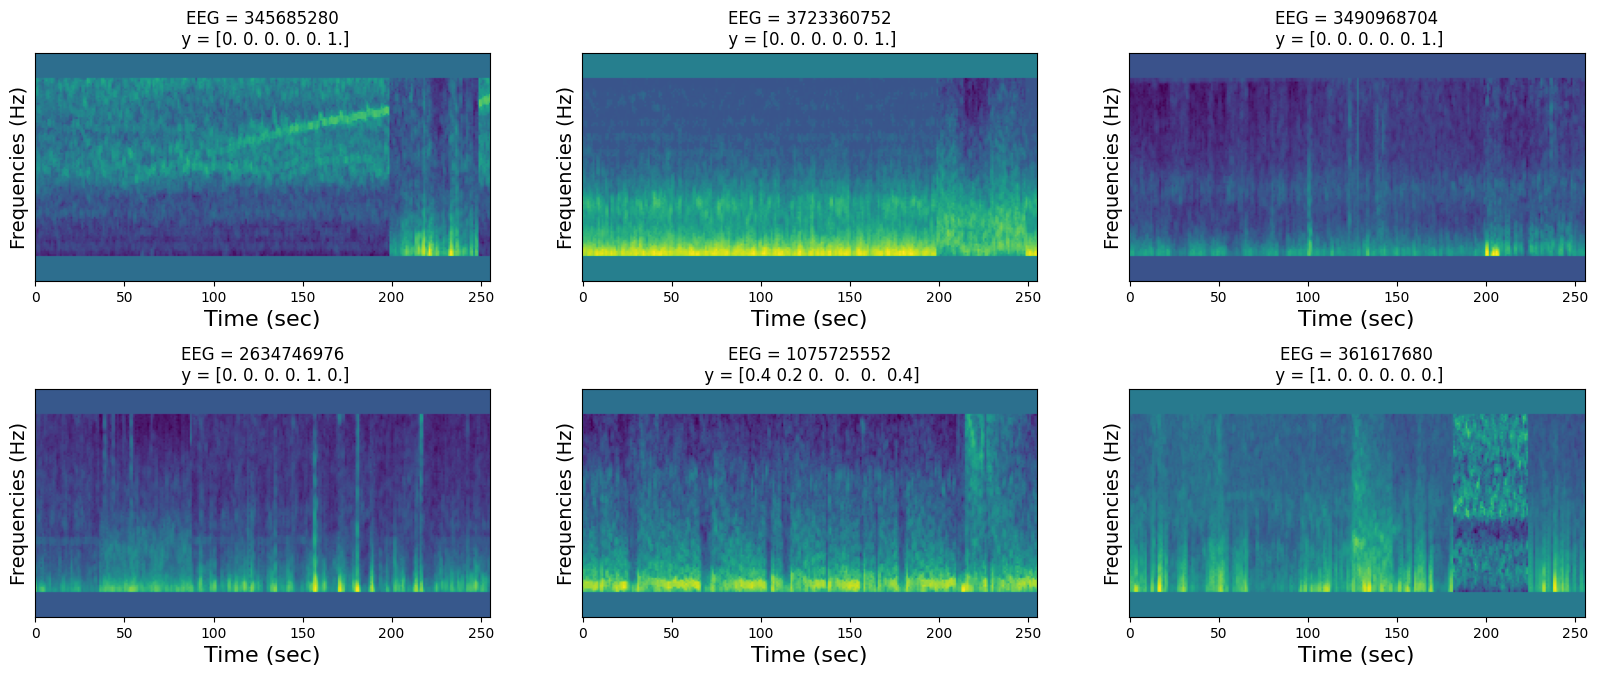

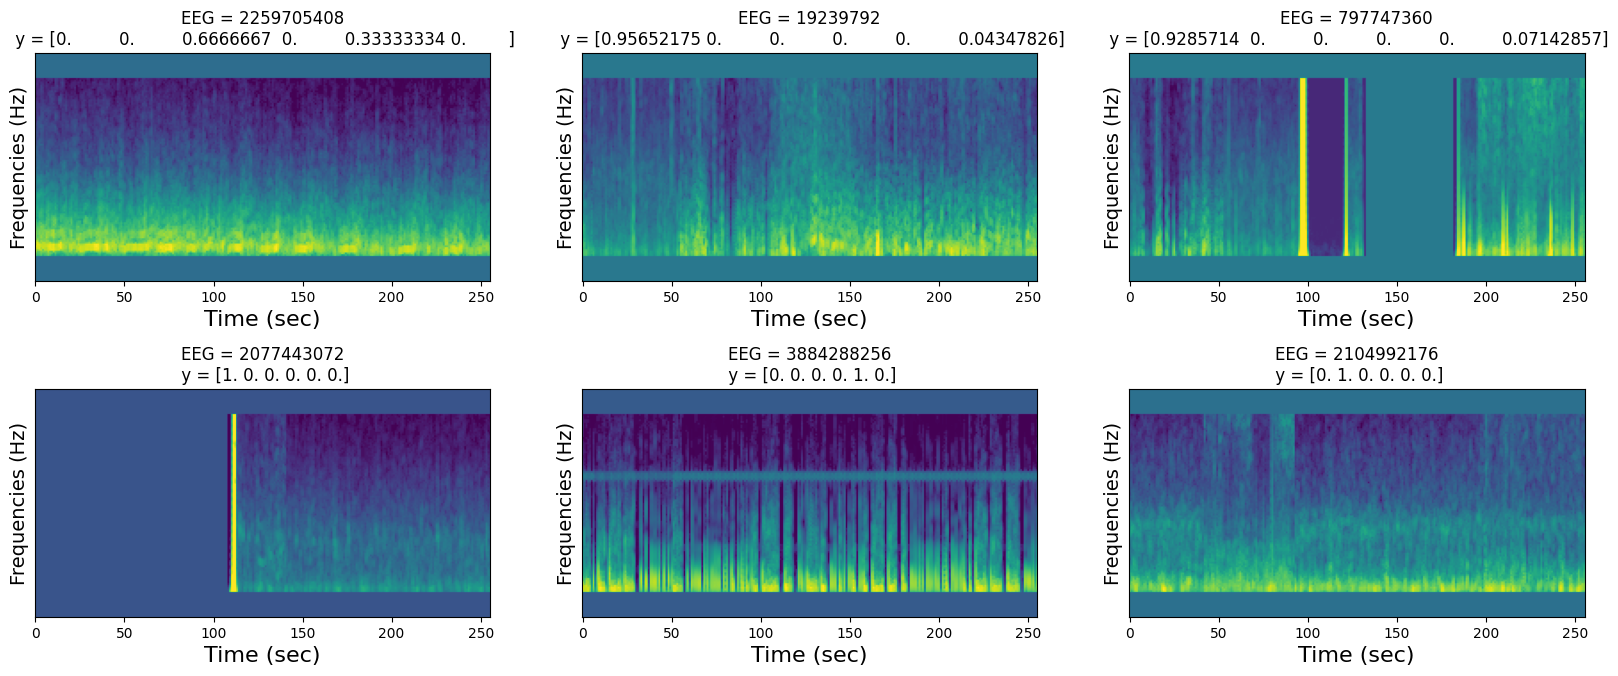

In [25]:
# dataloaderのスペクトログラム画像を表示

ROWS = 2
COLS = 3
BATCHES = 2

for i, (X, y) in enumerate(train_loader):
  plt.figure(figsize=(20,8))
  for j in range(ROWS):
    for k in range(COLS):
      plt.subplot(ROWS, COLS, j*COLS+k+1)

      img = X[j*COLS+k, :, :, 0][::-1,]

      min_value = img.flatten().min()
      max_value = img.flatten().max()
      img = (img-max_value) / (max_value-min_value)

      plt.imshow(img)

      y_s= y[j*COLS+k]

      y_texts = f"[{y_s[0]:0.2f}"
      for v in y_s[1:]:
        y_texts += f", {v:0.2f}"

      eeg = processed_train_df["eeg_id"].values[i*32+j*COLS+k]

      plt.title(f"EEG = {eeg}\n y = {y_s}", size=12)
      plt.yticks([])
      plt.ylabel("Frequencies (Hz)", size=14)
      plt.xlabel("Time (sec)", size=16)

  plt.show()

  if i == (BATCHES -1):
    break




### Train scheduler

- StepTrainScheduleで最初の4epochを学習
- LR = 1e-3 (1, 2epoch) -> 1e-4 (3epoch) -> 1e-5 (4epoch)

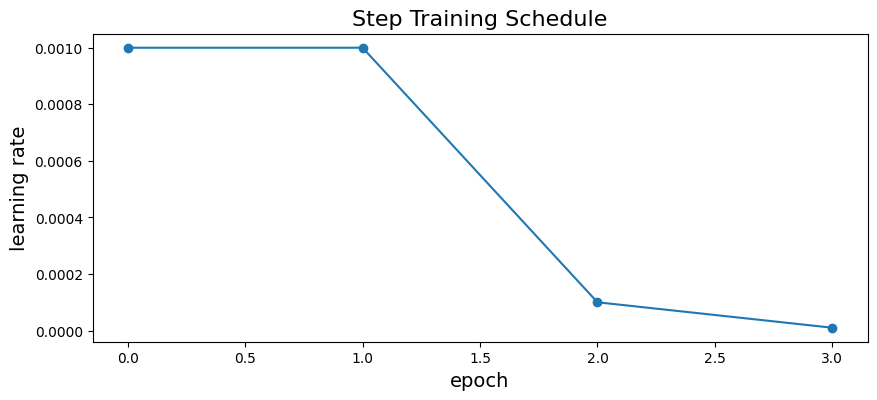

In [26]:
import math

def lrfn(epoch):
  if epoch < CFG.LR_RAMPUP_EPOCHS:
    lr = (CFG.LR_MAX - CFG.LR_START) / CFG.LR_RAMPUP_EPOCHS * epoch + CFG.LR_START
  elif epoch < (CFG.LR_RAMPUP_EPOCHS + CFG.LR_SUSTAIN_EPOCHS):
    lr = CFG.LR_MAX
  else:
    lr = CFG.LR_MAX * CFG.LR_STEP_DECAY ** ((epoch - CFG.LR_RAMPUP_EPOCHS - CFG.LR_SUSTAIN_EPOCHS) // CFG.EVERY)

  return lr

rng = [i for i in range(CFG.EPOCHS)]
y = [lrfn(x) for x in rng]

plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-')
plt.xlabel("epoch", size=14)
plt.ylabel("learning rate", size=14)
plt.title("Step Training Schedule", size=16)
plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


In [27]:
! pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
efficientnet is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [28]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

from src.models.efficientnet_b0 import EfficientNetB0

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_ix, valid_ix) in enumerate(gkf.split(processed_train_df, processed_train_df["label"], processed_train_df["patient_id"])):
  print(f"Fold {i+1}")

  train_loader = DataLoader(
    df=processed_train_df.iloc[train_ix],
    specs=specs,
    eegs=eegs,
    label_columns=label_columns,
    batch_size=32,
    shuffle=True,
    augment=True,
  )
  valid_loader = DataLoader(
    df=processed_train_df.iloc[valid_ix],
    specs=specs,
    eegs=eegs,
    label_columns=label_columns,
    batch_size=64,
    shuffle=False,
    mode="valid",
  )

  print(f"train size {len(train_ix)}, valid size {len(valid_ix)}")

  K.clear_session()

  with strategy.scope():
    model = EfficientNetB0.build_model()

  if CFG.LOAD_MODELS_FROM_TRAIN == "":
    model.fit(
      train_loader,
      verbose=1,
      validation_data=valid_loader,
      epochs=CFG.EPOCHS,
      callbacks=[LR],
    )

    model.save_weights(f"/kaggle/output/EfficientNet_v{CFG.VER}_f{i}.h5")
  else:
    model.load_weights(f"{CFG.LOAD_MODELS_FROM_TRAIN}/Efficient_v{CFG.VER}_f{i}.h5")

  oof = model.predict(valid_loader, verbose=1)

  all_oof.append(oof)
  all_true.append(processed_train_df.iloc[valid_ix][label_columns].values)

  del model, oof
  gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

Fold 1
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2024-03-04 10:53:03.054841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:53:03.055652: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
  

428/428 [==============================] - ETA: 0s - loss: 0.6890

2024-03-04 10:54:39.181697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:54:39.182015: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:16"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
 

428/428 [==============================] - 104s 201ms/step - loss: 0.6890 - val_loss: 0.7318 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4


2024-03-04 10:54:47.225654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:54:47.225735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.5389

2024-03-04 10:56:05.061420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:56:05.061501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:56:05.087208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:56:05.08

428/428 [==============================] - 85s 198ms/step - loss: 0.5389 - val_loss: 0.7817 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4


2024-03-04 10:56:12.237074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:56:12.237424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4286

2024-03-04 10:57:30.036883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:57:30.036996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:57:30.063300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:57:30.06

428/428 [==============================] - 85s 199ms/step - loss: 0.4286 - val_loss: 0.5455 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4


2024-03-04 10:57:37.303834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:57:37.304190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4027

2024-03-04 10:58:55.074708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:58:55.074787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:58:55.102244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:58:55.10

428/428 [==============================] - 85s 198ms/step - loss: 0.4027 - val_loss: 0.5398 - lr: 1.0000e-05


2024-03-04 10:59:02.548909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:59:02.549201: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:83"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
 

54/54 [==============================] - 8s 133ms/step
Fold 2
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2024-03-04 10:59:11.474078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 10:59:11.474431: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:99"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
 

428/428 [==============================] - ETA: 0s - loss: 0.7002

2024-03-04 11:00:44.150241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:00:44.150557: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:115"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - 100s 200ms/step - loss: 0.7002 - val_loss: 0.9195 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4


2024-03-04 11:00:51.758210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:00:51.758448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.5333

2024-03-04 11:02:09.641190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:02:09.641297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:02:09.673646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:02:09.67

428/428 [==============================] - 85s 199ms/step - loss: 0.5333 - val_loss: 0.6893 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4


2024-03-04 11:02:16.866270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:02:16.866645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4307

2024-03-04 11:03:34.813002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:03:34.813114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:03:34.839141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:03:34.83

428/428 [==============================] - 85s 199ms/step - loss: 0.4307 - val_loss: 0.5455 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4


2024-03-04 11:03:42.060623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:03:42.060846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4008

2024-03-04 11:04:59.973894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:04:59.973999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:04:59.999875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:04:59.99

428/428 [==============================] - 85s 199ms/step - loss: 0.4008 - val_loss: 0.5466 - lr: 1.0000e-05


2024-03-04 11:05:07.430780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:05:07.431118: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:182"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


54/54 [==============================] - 8s 132ms/step
Fold 3
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2024-03-04 11:05:16.323808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:05:16.324173: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:198"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - ETA: 0s - loss: 0.6996

2024-03-04 11:06:49.124371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:06:49.124698: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:214"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - 101s 200ms/step - loss: 0.6996 - val_loss: 0.7415 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4


2024-03-04 11:06:56.928710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:06:56.929069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.5294

2024-03-04 11:08:14.906056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:08:14.906134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:08:14.933432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:08:14.93

428/428 [==============================] - 85s 199ms/step - loss: 0.5294 - val_loss: 0.8352 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4


2024-03-04 11:08:22.211925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:08:22.212294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4271

2024-03-04 11:09:40.216875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:09:40.216953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:09:40.242584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:09:40.24

428/428 [==============================] - 85s 199ms/step - loss: 0.4271 - val_loss: 0.4856 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4


2024-03-04 11:09:47.516174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:09:47.516414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4019

2024-03-04 11:11:05.539813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:11:05.539923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:11:05.565884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:11:05.56

428/428 [==============================] - 85s 199ms/step - loss: 0.4019 - val_loss: 0.4928 - lr: 1.0000e-05


2024-03-04 11:11:13.043146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:11:13.043481: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:281"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


54/54 [==============================] - 8s 134ms/step
Fold 4
train size 13671, valid size 3418

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2024-03-04 11:11:22.017518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:11:22.017843: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:297"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - ETA: 0s - loss: 0.6957

2024-03-04 11:12:54.982731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:12:54.983042: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:313"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - 101s 200ms/step - loss: 0.6957 - val_loss: 1.3777 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4


2024-03-04 11:13:02.618712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:13:02.618967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.5246

2024-03-04 11:14:20.664636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:14:20.664718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:14:20.691629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:14:20.69

428/428 [==============================] - 85s 199ms/step - loss: 0.5246 - val_loss: 0.6630 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4


2024-03-04 11:14:27.874372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:14:27.874744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4169

2024-03-04 11:15:45.803909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:15:45.803994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:15:45.830289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:15:45.83

428/428 [==============================] - 85s 199ms/step - loss: 0.4169 - val_loss: 0.5572 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4


2024-03-04 11:15:53.086084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:15:53.086451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.3875

2024-03-04 11:17:11.110727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:17:11.110815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:17:11.136563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:17:11.13

428/428 [==============================] - 85s 199ms/step - loss: 0.3875 - val_loss: 0.5250 - lr: 1.0000e-05


2024-03-04 11:17:18.623514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:17:18.623853: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:380"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


54/54 [==============================] - 8s 134ms/step
Fold 5
train size 13672, valid size 3417

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2024-03-04 11:17:27.611628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:17:27.612002: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:396"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - ETA: 0s - loss: 0.7057

2024-03-04 11:19:00.470590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:19:00.470886: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:412"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


428/428 [==============================] - 101s 200ms/step - loss: 0.7057 - val_loss: 0.8336 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/4


2024-03-04 11:19:08.363410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:19:08.363488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.5333

2024-03-04 11:20:25.858668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:20:25.858748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:20:25.885272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:20:25.88

428/428 [==============================] - 85s 198ms/step - loss: 0.5333 - val_loss: 0.6274 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/4


2024-03-04 11:20:33.073316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:20:33.073582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4378

2024-03-04 11:21:50.587109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:21:50.587199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:21:50.613923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:21:50.61

428/428 [==============================] - 85s 198ms/step - loss: 0.4378 - val_loss: 0.4818 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
Epoch 4/4


2024-03-04 11:21:57.806913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:21:57.807182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.4007

2024-03-04 11:23:15.205292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:23:15.205378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:23:15.231462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:23:15.23

428/428 [==============================] - 85s 197ms/step - loss: 0.4007 - val_loss: 0.4774 - lr: 1.0000e-05


2024-03-04 11:23:22.649170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-04 11:23:22.649517: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:479"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {


54/54 [==============================] - 8s 133ms/step


### CV score for EfficientNet

KL(=Kullback-Leibler) Divergenceによる性能評価
https://qiita.com/shuva/items/81ad2a337175c035988f

In [29]:
from src.metrics import kl_div

oof = pd.DataFrame(all_oof.copy())
oof["id"] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true["id"] = np.arange(len(true))

cv = kl_div.score(solution=true, submission=oof, row_id_column_name="id")

print("CV score KL-Div for EfficientNetB0=", cv)

CV score KL-Div for EfficientNetB0= 0.5173740608465734
